# Machine Learning Engineer Nanodegree

## Project: Predicting WTI spot prices

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.

For this project, we build a WTI spot price predictor. This predictor: 
1. Takes different kind of data: 
    big set of historical fundatmenatal data, 
    technical indicators, calculated using historical price
    price of related assets (Brent spot price, WTI futures contracts)
2.  provide projected estimates for given query dates



## Import libraries and load data



In [1]:
# Import libraries necessary for this project

##libraries for dataset loading and processing
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
from dateutil import parser
import datetime

##libraries to define performance metrics
from sklearn.metrics import mean_squared_error
import math as m
import matplotlib.pylab as plt

# Pretty display for notebooks
%matplotlib inline



#libraries to normalize data.
from sklearn import preprocessing

#libraries to build models. We'll build models based on Support Vector Regression Model and theano Sequental Neural Network 
from sklearn.svm import SVR

from keras import backend
from keras.models import Sequential
from keras.layers import Dense

#libraries to fine optimal hyperparameters
from sklearn.model_selection import ParameterGrid
from keras.wrappers.scikit_learn import KerasRegressor
from keras.constraints import maxnorm


# Load the dataset

data = pd.read_csv('data.csv', index_col='Date', keep_date_col = True)
prices1 = data['1_WTI_Spot'].shift(-1)
prices3 = data['1_WTI_Spot'].shift(-3)
prices6 = data['1_WTI_Spot'].shift(-6)
features = data

# Success
print "Dataset has {} data points with {} variables each.".format(*data.shape)



Using Theano backend.


Dataset has 372 data points with 19 variables each.


## Process and normalize data
 

### Add new technical features




In [2]:
##Adding some technical indicators

features['7_6m_ma'] = pd.rolling_mean(features['1_WTI_Spot'], window=6)
features['7_12m_ma'] = pd.rolling_mean(features['1_WTI_Spot'], window=12)
features['7_Bol_upper'] = features['7_6m_ma'] + 2* pd.rolling_std(features['1_WTI_Spot'], 6, min_periods=6)
features['7_Bol_lower'] = features['7_6m_ma'] - 2* pd.rolling_std(features['1_WTI_Spot'], 6, min_periods=6)
features['7_Bol_BW'] = ((features['7_Bol_upper'] - features['7_Bol_lower'])/features['7_6m_ma'])*100
features['7_6m_exma'] = pd.ewma(features['1_WTI_Spot'], span=6)
features['7_12m_exma'] = pd.ewma(features['1_WTI_Spot'], span=12)
features['7_DailyReturn'] = (features['1_WTI_Spot'].pct_change()+1)*100

# Success
print "Dataset has {} data points with {} variables each.".format(*data.shape)


Dataset has 372 data points with 27 variables each.


### Cut dataset to exclude missing data

In [3]:
##Cut dataset to eliminate rows with NaN values

strdate = 'Jan-88'
etedate = 'Jun-16'

SelectedFeatures = features.copy()
SelectedFeatures = SelectedFeatures[strdate:etedate]

SelectedPrices1 = prices1.copy()
SelectedPrices1 = prices1[strdate:etedate]

SelectedPrices3 = prices3.copy()
SelectedPrices3 = prices3[strdate:etedate]

SelectedPrices6 = prices6.copy()
SelectedPrices6 = prices6[strdate:etedate]

print  "Quantity of empty features for filtered dataset is {}; ".format(SelectedFeatures.isnull().sum().sum()) 
print  "for 1-Month price prediction dataset is {};".format(SelectedPrices1.isnull().sum()) 
print  "for 3-Month price prediction dataset is {}; ".format(SelectedPrices3.isnull().sum()),
print "\n"+"for 6-Month price prediction dataset is {}; ".format(SelectedPrices6.isnull().sum())

Quantity of empty features for filtered dataset is 0; 
for 1-Month price prediction dataset is 0;
for 3-Month price prediction dataset is 0;  
for 6-Month price prediction dataset is 0; 


### Normalize data




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002D8831D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000002D995470>]], dtype=object)

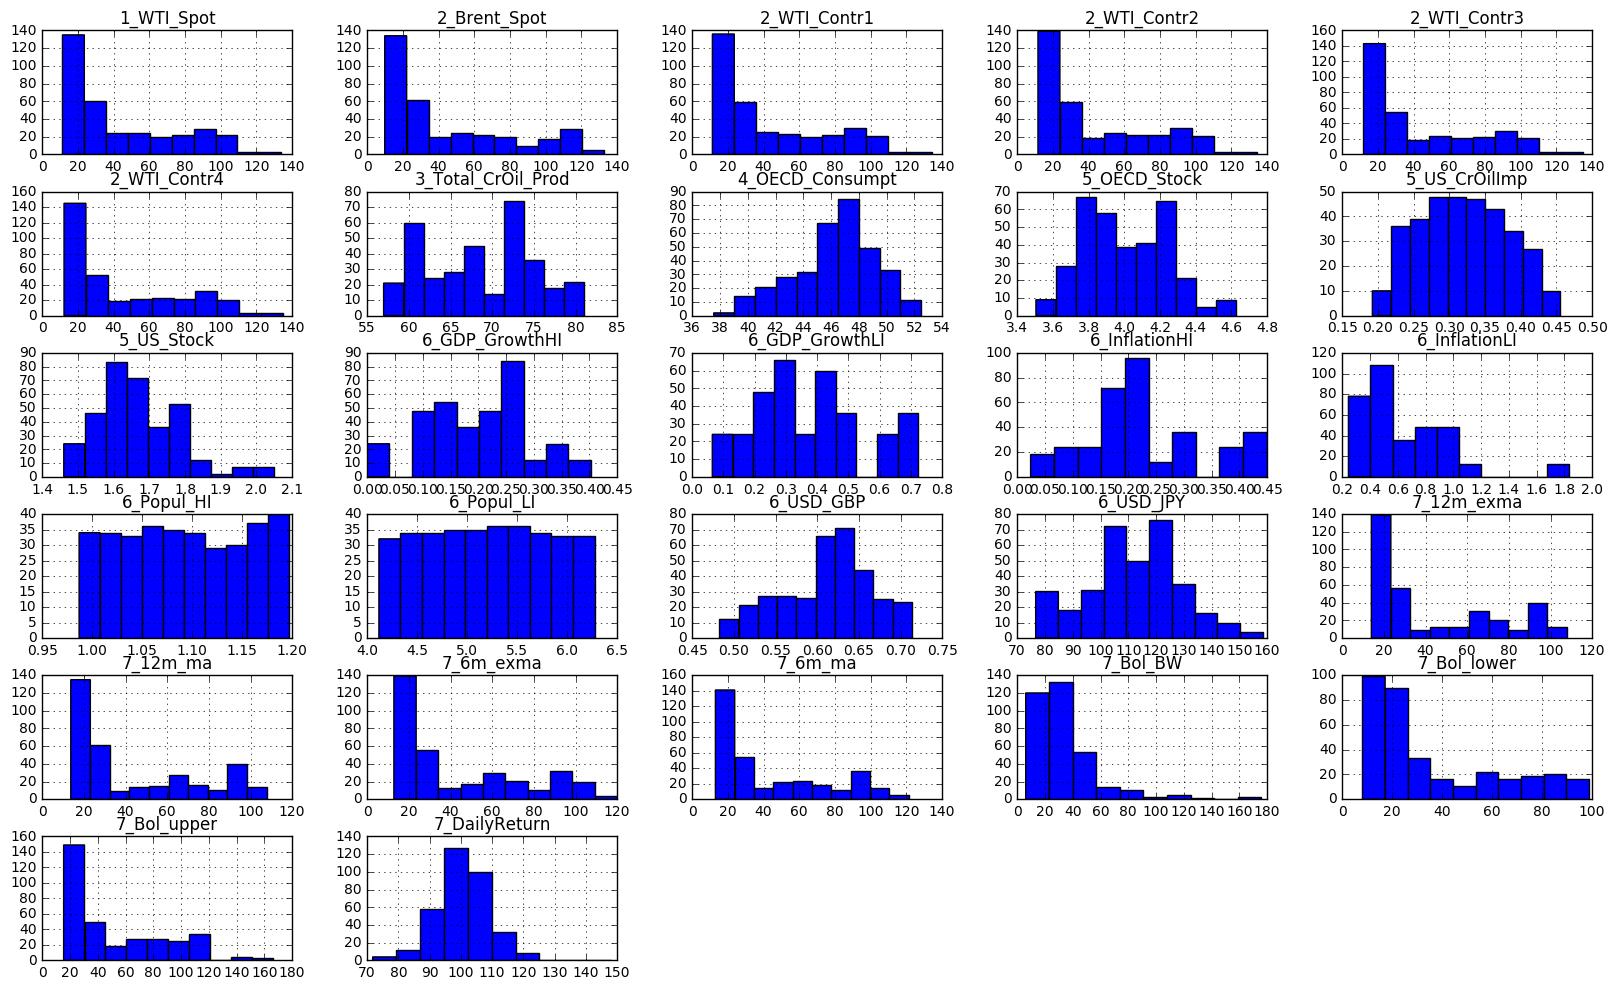

In [61]:
#Analyze current distribution of data

SelectedFeatures.hist( figsize=(20,12 ))


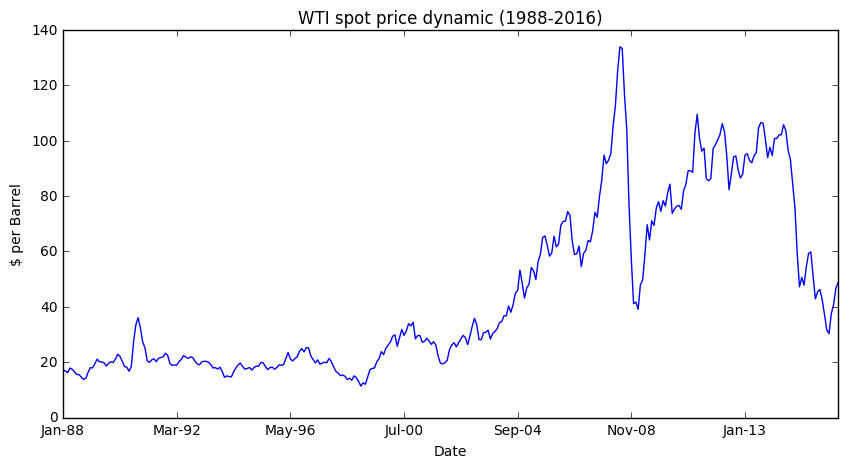

In [4]:
##Plot figure with price dynamics to analyze stationarity of the series
ax = SelectedFeatures['1_WTI_Spot'].plot(title = 'WTI spot price dynamic (1988-2016)',figsize=(10,5 ) )
ax.set_ylabel('$ per Barrel')

As we can see from statistic above, the featureas have different scale and not normally distributed. We should pre-process these data. For that we try to apply three type of transformation that work better with time-series:
1. Z-score transformation 
2. Log-transformation
3. Feature normalisation from sklearn

In [4]:
##Normalize features. three options

#Zstat
featuresZ = SelectedFeatures.copy()
featuresZ= (features - features.mean())/features.std(ddof=0)

#Log normalization (in this case we should not affect Daily Return because it can be negative)
featuresLog = SelectedFeatures.copy()
#featuresLog = featuresLog.drop(['7_DailyReturn'] , axis = 1)
featuresLog= np.log (featuresLog)
#featuresLog['7_DailyReturn'] = features['7_DailyReturn'] 


#Normalize from sklearn
featuresNorm = SelectedFeatures.copy()
featuresNorm= preprocessing.normalize(featuresNorm, norm='l1')
featuresNorm = pd.DataFrame(data=featuresNorm, index = SelectedFeatures.index, columns= list(SelectedFeatures))


----

## Developing a Model
In this second section we will develop the tools and techniques necessary for a model to make a prediction.

### Implementation: Define a Performance Metric




In [5]:
def rms(targets, pred):
    return round(m.sqrt(mean_squared_error(targets, pred)),2)

def Dstat(target,pred):
    DstatArray = target.copy()
    DstatArray = pd.concat([DstatArray,pred], axis=1 )
    DstatValue = (((DstatArray[0].diff()*DstatArray['1_WTI_Spot'].diff()>=0).sum())*1.0 /DstatArray[0].diff().count())*100
    return round(DstatValue,2)


### Implementation: Choose date range for training and testing dataset


In [6]:
#Usually the optimal training/testing split is 80/20 rule. We calculate the spliting point based on start and end date range

SplitRatio = 0.8

#Calculate total number of rows for feature dataset
NbFeatureRows = SelectedFeatures.shape[0]

#find rowNb to split train and test dataset
SplitRow = int(NbFeatureRows*SplitRatio)

etrdate = SelectedFeatures.index.values[SplitRow] #Calculate end date range of trainig data 
stedate = SelectedFeatures.index.values[SplitRow+1] #Calculate start date of trainig data 


### Implementation: Choose Scaling/normalization rules for training/testing dataset

In [15]:
#Create train and test set based on different scaling/normalization rules. Then test prediction quality for each train/test set

#we test the efficiency of scaling/normalization rules on simple SVR model
clf = SVR()

#Set of rule names
NormRules = ['Z','Log', 'Norm']


#For simplicity, we test the efficiency of scaling/normalization rules making only 1-month price predictions
y_train1 = SelectedPrices1.copy()
y_train1 = y_train1[strdate:etrdate]

y_test1 = SelectedPrices1.copy()
y_test1 = SelectedPrices1[stedate:etedate]



for x in NormRules:
    print "\n"+"Testing predicton quality based on {} scaling/normalization rule:".format(x)
    featuresname = 'features'+x
    X_trainName = 'X_train'+x
    X_testName = 'X_test'+x
    X_trainName = eval(featuresname).copy()
    X_trainName = X_trainName[strdate:etrdate]
    X_testName = eval(featuresname).copy()
    X_testName = X_testName[stedate:etedate]
    
    clf.fit(X_trainName, y_train1)
    
    y_predTr = clf.predict(X_trainName)
    y_predTr = pd.DataFrame([y_predTr]).T
    y_predTr = y_predTr.set_index(y_train1.index)
    print "For training data RMSE is {} while Direct Accuracy is {}:".format(rms(y_train1, y_predTr), Dstat(y_train1, y_predTr))
    
    y_predTe = clf.predict(X_testName)
    y_predTe = pd.DataFrame([y_predTe]).T
    y_predTe = y_predTe.set_index(y_test1.index)
    print "For testing data RMSE is {} while Direct Accuracy is {}:".format(rms(y_test1, y_predTe), Dstat(y_test1, y_predTe))



Testing predicton quality based on Z scaling/normalization rule:
For training data RMSE is 12.28 while Direct Accuracy is 51.65:
For testing data RMSE is 31.41 while Direct Accuracy is 53.73:

Testing predicton quality based on Log scaling/normalization rule:
For training data RMSE is 11.14 while Direct Accuracy is 54.21:
For testing data RMSE is 25.46 while Direct Accuracy is 53.73:

Testing predicton quality based on Norm scaling/normalization rule:
For training data RMSE is 27.14 while Direct Accuracy is 49.08:
For testing data RMSE is 61.41 while Direct Accuracy is 47.76:


In [11]:
#As a result of calculation made above we select to use Log normalization accuracy

selectedNormMethod = 'Log'
featuresname = 'features'+selectedNormMethod

X_train = eval(featuresname).copy()
X_train = X_train[strdate:etrdate]

X_test = eval(featuresname).copy()
X_test = X_test[stedate:etedate]

#Also introduce price prediction datasets for 3-month and 6-month time horizon

y_train3 = SelectedPrices3.copy()
y_train3 = y_train3[strdate:etrdate]
y_test3 = SelectedPrices3.copy()
y_test3 = SelectedPrices3[stedate:etedate]

y_train6 = SelectedPrices6.copy()
y_train6 = y_train6[strdate:etrdate]
y_test6 = SelectedPrices6.copy()
y_test6 = SelectedPrices6[stedate:etedate]

----

## Compare baseline models and evaluate performance


### Introduce some functions to build descriptive statistic

In [7]:
#Function to plot actual and predicted WTI spot-price on real timeline axis 
# (e.g. when we form price timeseries for 6-month prediction, we shift actual spot price for 6 month back, 
#this function put price time-series on x-month forward  )   
def PlotShiftedData(x, target, pred):
    x = int(x)
    plotArray = target.copy()
    plotArray = plotArray.values
    plotArray = pd.DataFrame([plotArray]).T
    ShifteSdate= parser.parse('15-'+stedate)+datetime.timedelta(days=x*30)
    newIndex = pd.date_range(ShifteSdate, periods=plotArray.shape[0], freq='M')
    newIndex = newIndex.strftime('%b-%y')
    plotArray = plotArray.set_index(newIndex)
    
    pred = pred.set_index(newIndex)
    plotArray = pd.concat([plotArray,pred], axis=1 )
    plotArray.columns = ['WTI_Spot_Actual_price', 'WTI_Spot_prediction_price']
    title = "{}-month prediction of WTI spot price".format(x)
    plotArray.plot(title=title)


-----

### SVR Basic



Testing predicton quality based for 1-month prediction:
For training data RMSE is 5.81 while Direct Accuracy is 53.85:
For testing data RMSE is 10.22 while Direct Accuracy is 61.19:

Testing predicton quality based for 3-month prediction:
For training data RMSE is 8.76 while Direct Accuracy is 51.28:
For testing data RMSE is 16.04 while Direct Accuracy is 40.3:

Testing predicton quality based for 6-month prediction:
For training data RMSE is 10.07 while Direct Accuracy is 56.04:
For testing data RMSE is 18.31 while Direct Accuracy is 40.3:


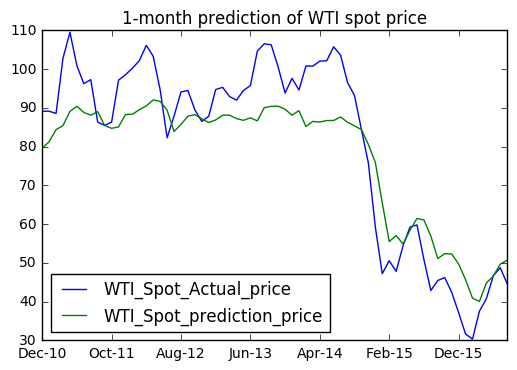

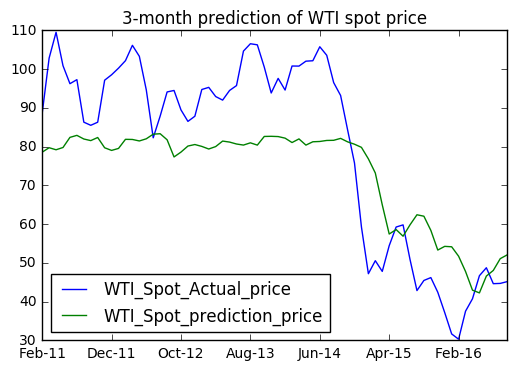

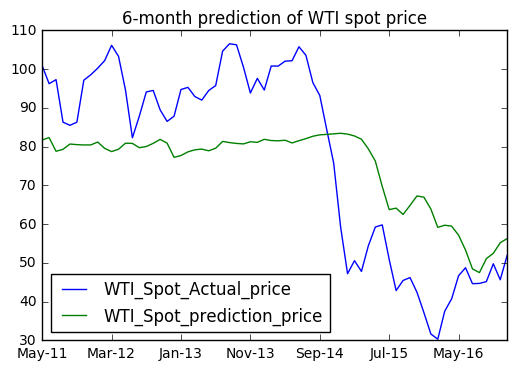

In [15]:
#Calculate RMSE and Directional Accuracy for price for different time horizons 

clf = SVR(C=10)
PricePredRange = ['1','3','6']

for x in PricePredRange:
    print "\b"+"\n"+"Testing predicton quality based for {}-month prediction:".format(x)
    y_trainName = 'y_train'+x
    y_testName = 'y_test'+x
      
    clf.fit(X_train, eval(y_trainName))
    
    y_predTr = clf.predict(X_train)
    y_predTr = pd.DataFrame([y_predTr]).T
    y_predTr = y_predTr.set_index(eval(y_trainName).index)
    print "For training data RMSE is {} while Direct Accuracy is {}:".format(rms(eval(y_trainName), y_predTr), Dstat(eval(y_trainName), y_predTr))
    
    y_predTe = clf.predict(X_test)
    y_predTe = pd.DataFrame([y_predTe]).T
    y_predTeI = y_predTe.set_index(eval(y_testName).index)
    print "For testing data RMSE is {} while Direct Accuracy is {}:".format(rms(eval(y_testName), y_predTeI), Dstat(eval(y_testName), y_predTeI))
    PlotShiftedData(x,eval(y_testName),y_predTe)


-----

### NN Basic


Testing predicton quality based for 1-month prediction:
For training data RMSE is 5.76 while Direct Accuracy is 54.21:
For testing data RMSE is 9.5 while Direct Accuracy is 56.72:

Testing predicton quality based for 3-month prediction:
For training data RMSE is 8.3 while Direct Accuracy is 54.21:
For testing data RMSE is 11.74 while Direct Accuracy is 44.78:

Testing predicton quality based for 6-month prediction:
For training data RMSE is 10.31 while Direct Accuracy is 51.28:
For testing data RMSE is 13.89 while Direct Accuracy is 43.28:


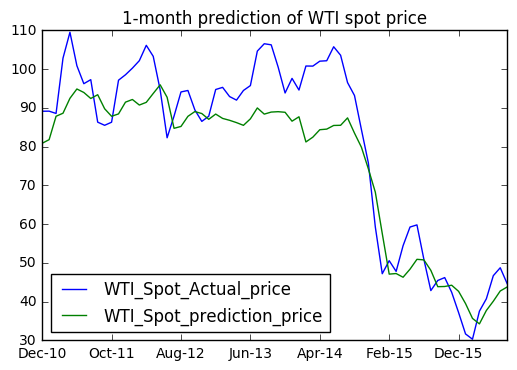

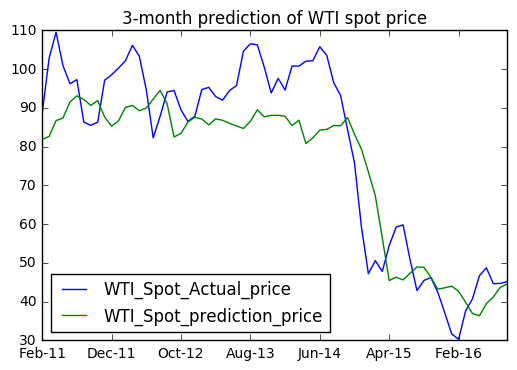

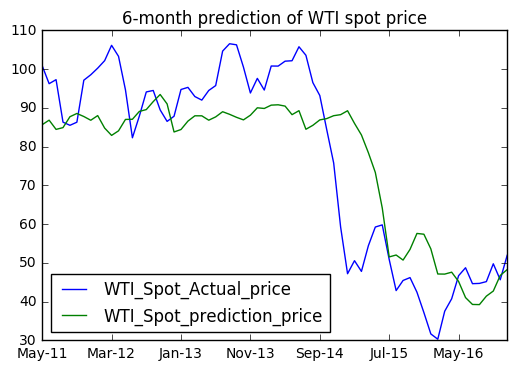

In [41]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(27, input_dim=27, activation='relu'))
model.add(Dense(13))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(X_train.values, y_train, nb_epoch=25, batch_size=2, verbose=0)


PricePredRange = ['1','3','6']

for x in PricePredRange:
    print "\b"+"\n"+"Testing predicton quality based for {}-month prediction:".format(x)
    y_trainName = 'y_train'+x
    y_testName = 'y_test'+x
    
    model.fit(X_train.values, eval(y_trainName), nb_epoch=100, batch_size=4, verbose=0)
      
    y_predTr = model.predict(X_train.values)
    y_predTr = map (float, y_predTr)
    y_predTr = pd.DataFrame([y_predTr]).T
    y_predTrI = y_predTr.set_index(eval(y_trainName).index)
    print "For training data RMSE is {} while Direct Accuracy is {}:".format(rms(eval(y_trainName), y_predTrI), Dstat(eval(y_trainName), y_predTrI))
    
    y_predTe = model.predict(X_test.values)
    y_predTe = map (float, y_predTe)
    y_predTe = pd.DataFrame([y_predTe]).T
    y_predTeI = y_predTe.set_index(eval(y_testName).index)
    print "For testing data RMSE is {} while Direct Accuracy is {}:".format(rms(eval(y_testName), y_predTeI), Dstat(eval(y_testName), y_predTeI))
    PlotShiftedData(x,eval(y_testName),y_predTe)


----

## Fit best model


### Introduce some functions to build descriptive statistic

In [71]:
##Function to print summarized result of hyperparameters search 
## for each combination of hyperparameters (groupby1 and groupby2) to analyze the quality prediction
def KPISummary (arrayName, groupby1, groupby2, period):
    print '\n'+'{}-month prediction results'.format(period)
    for stNb in ['1', '2']:
        groupname = 'groups'+stNb
        groupby = eval('groupby'+stNb)
        groupname = arrayName[arrayName.Period==period].groupby(groupby) 
        groupbyArr = []
        groupbyArr = pd.DataFrame()
        groupbyArr['Mean_Dstat'] = groupname.Dstat.mean()
        groupbyArr['Std_Dstat'] = groupname.Dstat.std()
        groupbyArr['Mean_RMSE'] = groupname.RMS.mean()
        groupbyArr['Std_RMSE'] = groupname.RMS.std()
        print groupbyArr
    return ''


##Function to plot scatters with KPIs (RMS and Dstat) from array buld as result of hyperparameters search 
## for each combination of hyperparameters (groupby1 and groupby2) to analyze the quality prediction

def PlotParameterScatter(arrayName, groupby1, groupby2, period):
    groups1 = arrayName[arrayName.Period==period].groupby(groupby1)
    groups2 = arrayName[arrayName.Period==period].groupby(groupby2)

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 6))

    for name, group in groups1:
        ax1.plot(group.Dstat, group.RMS, marker='o', linestyle='', ms=12, label=name)
    ax1.legend(loc=2)

    for name, group in groups2:
        ax2.plot(group.Dstat, group.RMS, marker='v', linestyle='', ms=12, label=name)
    ax2.legend(loc=2)

    f.text(0.5, 0.04, 'Dstat', ha='center')
    f.text(0.04, 0.5, 'RMS', va='center', rotation='vertical')
    plt.suptitle('{}-month prediction results'.format(period))

    ax1.set_title('Parameters values (color = {}-value )'.format(groupby1))
    ax2.set_title('Parameters values (color = {}-value )'.format(groupby2))

    return KPISummary (arrayName, groupby1, groupby2, period), plt.show()

### NN hyperparameters searching

In [8]:
# Function to create model, required for KerasRegressor
def create_model(neurons1L=1,neurons2L=1 ):
    # create model
    model = Sequential()
    model.add(Dense(neurons1L, input_dim=27, activation='relu'))
    model.add(Dense(neurons2L))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

In [100]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasRegressor(build_fn=create_model, nb_epoch=100, batch_size=4, verbose=0)
neurons1L = [27,54,108,216,532,1064]
neurons2L = [15, 27, 54, 80,160,320]
param_grid = dict(neurons1L=neurons1L, neurons2L=neurons2L)

#Create array with hyperparameters and results

NNGridSearchArray = []

for x in PricePredRange:
    y_trainName = 'y_train'+x
    y_testName = 'y_test'+x
    for g in ParameterGrid(param_grid):
        model.set_params(**g)
        model.fit(X_train.values,eval(y_trainName))
        y_predNNOpt = model.predict(X_test.values)
        y_newOpt = map (float, y_predNNOpt)
        y_newOpt = pd.DataFrame([y_newOpt]).T
        y_newOpt = y_newOpt.set_index(eval(y_testName).index)
        #print g, rms(y_test1, y_newOpt), Dstat(y_test1, y_newOpt)
        NNGridSearchArray.append({'Period':x, 'neurons1L': g['neurons1L'], 'neurons2L': g['neurons2L'], 'RMS':
            rms(eval(y_testName), y_newOpt), 'Dstat':Dstat(eval(y_testName), y_newOpt)})

NNGridSearchArray = pd.DataFrame(NNGridSearchArray)

print "Parameters search is completed"

Parameters search is completed


### NN hyperparameters analyzing and selecting



1-month prediction results
           Mean_Dstat  Std_Dstat  Mean_RMSE  Std_RMSE
neurons1L                                            
27          57.958333   2.737922  12.816667  2.272802
54          58.458333   2.572185  11.880000  2.834001
108         59.700000   0.942359  13.900000  2.704973
216         60.445000   1.246623  13.330000  2.406267
532         60.445000   1.246623  14.606667  2.934060
1064        61.190000   0.000000  14.306667  1.646957
           Mean_Dstat  Std_Dstat  Mean_RMSE  Std_RMSE
neurons2L                                            
15          59.948333   1.741877  14.021667  1.328479
27          59.700000   1.332697  14.435000  0.881516
54          59.450000   2.390640  12.805000  1.524228
80          59.451667   1.980449  13.563333  2.020343
160         59.946667   2.391056  13.975000  3.639268
320         59.700000   2.670985  12.040000  4.102702


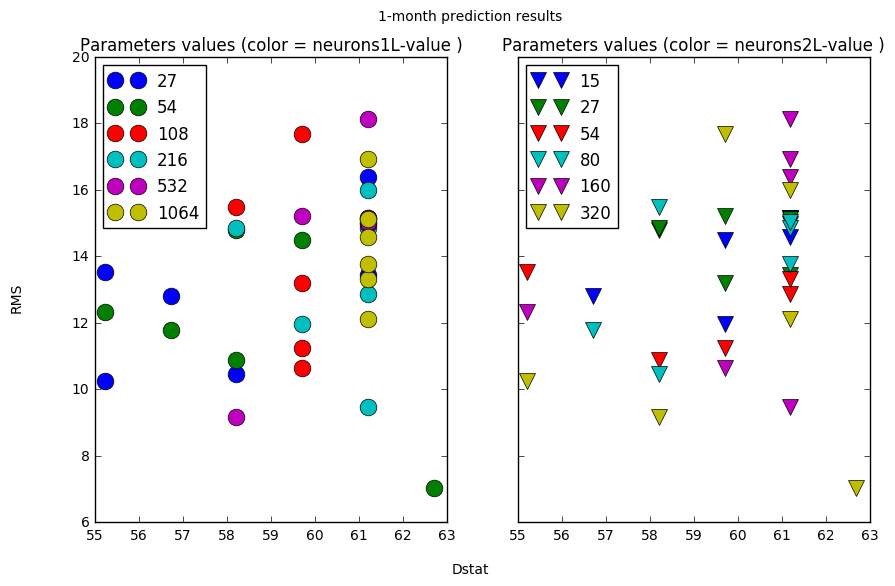


3-month prediction results
           Mean_Dstat  Std_Dstat  Mean_RMSE  Std_RMSE
neurons1L                                            
27          46.020000   2.569669  14.455000  2.111310
54          46.516667   2.196166  15.563333  4.208998
108         45.523333   1.565588  15.376667  3.563407
216         43.780000   0.774597  17.580000  4.120252
532         42.783333   1.216580  18.048333  6.517688
1064        43.280000   0.000000  15.921667  5.203643
           Mean_Dstat  Std_Dstat  Mean_RMSE  Std_RMSE
neurons2L                                            
15          46.018333   2.737922  16.090000  3.558011
27          45.521667   2.058178  16.616667  2.641550
54          43.780000   0.774597  14.395000  2.202115
80          45.023333   2.197978  19.820000  3.459069
160         44.526667   1.470043  15.090000  7.392710
320         43.033333   1.983710  14.933333  4.297914


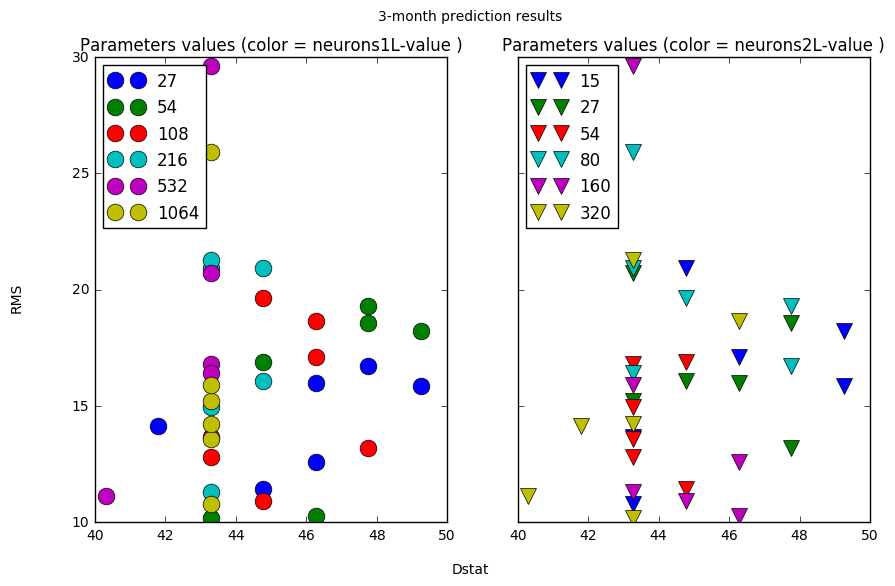


6-month prediction results
           Mean_Dstat  Std_Dstat  Mean_RMSE  Std_RMSE
neurons1L                                            
27          44.278333   2.438060  18.703333  3.565460
54          44.526667   1.746158  18.375000  2.685083
108         45.275000   1.219848  17.063333  2.878372
216         45.275000   1.219848  18.940000  3.074254
532         44.778333   0.945525  17.640000  3.155116
1064        44.526667   1.746158  19.506667  4.005784
           Mean_Dstat  Std_Dstat  Mean_RMSE  Std_RMSE
neurons2L                                            
15          45.523333   1.565588  18.658333  4.334736
27          44.278333   1.221481  17.076667  1.796738
54          45.275000   2.039144  20.240000  4.200790
80          45.773333   1.216580  19.636667  2.911382
160         44.028333   1.251406  16.918333  2.314246
320         43.781667   1.221481  17.698333  1.904147


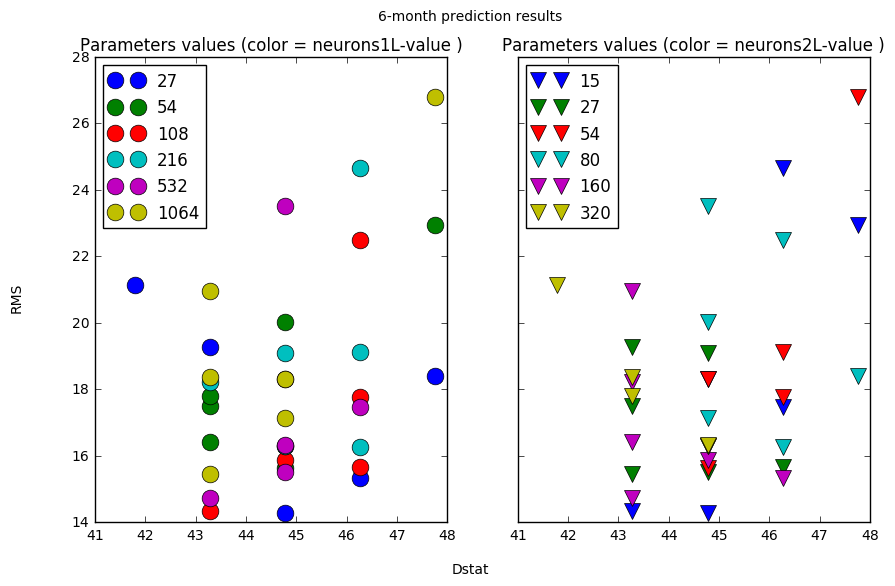

In [101]:
for z in PricePredRange:
    PlotParameterScatter(NNGridSearchArray, 'neurons1L', 'neurons2L', z)

### SVR hyperparameters searching

In [102]:
#Set values for parameter grid
C = [10,20,30,50,70,80, 100, 200, 1000]
gamma = [0.5, 0.1, 0.001, 0.0001, 0.00001]
param_grid = dict(C=C, gamma=gamma)

#Create array with hyperparameters and results
SVRGridSearchArray = []

#Calculate performance indcators for each combination of hyperparameters
clf = SVR(kernel='rbf')

for x in PricePredRange:
    y_trainName = 'y_train'+x
    y_testName = 'y_test'+x
    for g in ParameterGrid(param_grid):
        clf.set_params(**g)
        clf.fit(X_train,eval(y_trainName))
        y_predSVROpt = clf.predict(X_test)
        y_newSVROpt = pd.DataFrame([y_predSVROpt]).T
        y_newSVROpt = y_newSVROpt.set_index(eval(y_testName).index)
        #print g, rms(y_test1, y_newOpt), Dstat(y_test1, y_newOpt)
        SVRGridSearchArray.append({'Period':x, 'C': g['C'], 'gamma': g['gamma'], 'RMS':
            rms(eval(y_testName), y_newSVROpt), 'Dstat':Dstat(eval(y_testName), y_newSVROpt)})

SVRGridSearchArray = pd.DataFrame(SVRGridSearchArray)
print "Parameters search is completed"
#print SVRGridSearchArray


Parameters search is completed



1-month prediction results
      Mean_Dstat  Std_Dstat  Mean_RMSE   Std_RMSE
C                                                
10        59.102   2.263983     37.836  21.676965
20        60.598   2.004263     34.256  22.032496
30        59.402   2.872572     32.392  21.948717
50        59.702   2.359061     30.410  21.088249
70        60.296   1.332697     28.948  20.362820
80        60.296   1.332697     28.424  20.042511
100       60.296   1.332697     27.496  19.525046
200       59.106   4.904552     25.196  17.479176
1000      59.400   2.669307     20.398  10.361343
         Mean_Dstat  Std_Dstat  Mean_RMSE   Std_RMSE
gamma                                               
0.00001   59.865556   0.496667  56.115556   8.310838
0.00010   61.025556   0.897693  40.292222  12.837315
0.00100   61.524444   0.997711  20.448889   7.066761
0.10000   59.036667   2.702809   8.343333   1.671967
0.50000   57.546667   3.262327  22.220000   2.510219


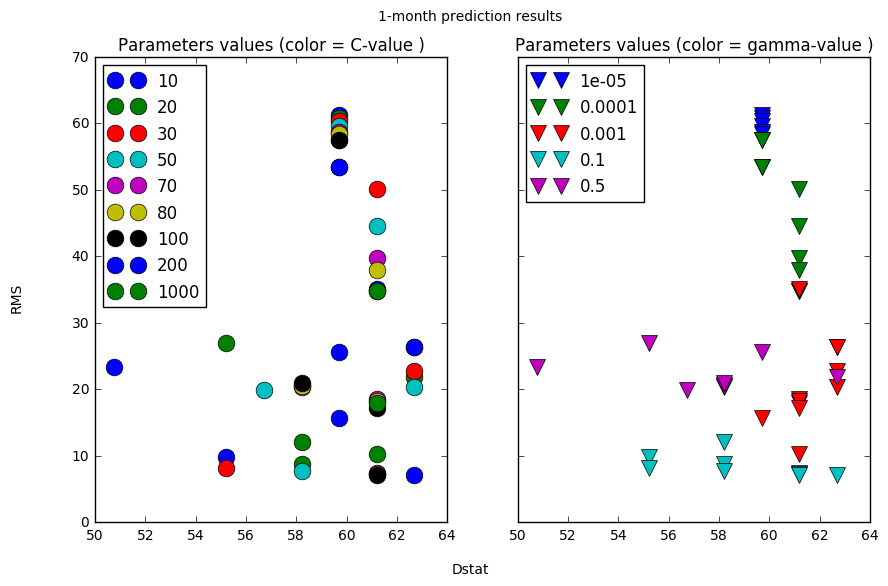


3-month prediction results
      Mean_Dstat  Std_Dstat  Mean_RMSE   Std_RMSE
C                                                
10        39.404   2.263654     38.760  18.988048
20        38.508   1.947709     34.390  20.427395
30        38.508   1.947709     32.718  20.279946
50        37.910   2.498029     30.874  19.843335
70        38.808   2.585086     29.624  19.009622
80        38.806   2.112482     29.116  18.644167
100       39.106   2.213737     28.390  18.079663
200       39.104   1.947326     25.412  16.184402
1000      38.508   3.865077     21.900   8.420273
         Mean_Dstat  Std_Dstat  Mean_RMSE   Std_RMSE
gamma                                               
0.00001   40.134444   0.496667  55.044444   7.329504
0.00010   39.470000   1.318152  40.667778  11.879032
0.00100   37.478889   1.386258  22.204444   6.353123
0.10000   35.986667   1.385208  12.584444   2.260996
0.50000   40.631111   2.211456  20.156667   2.164353


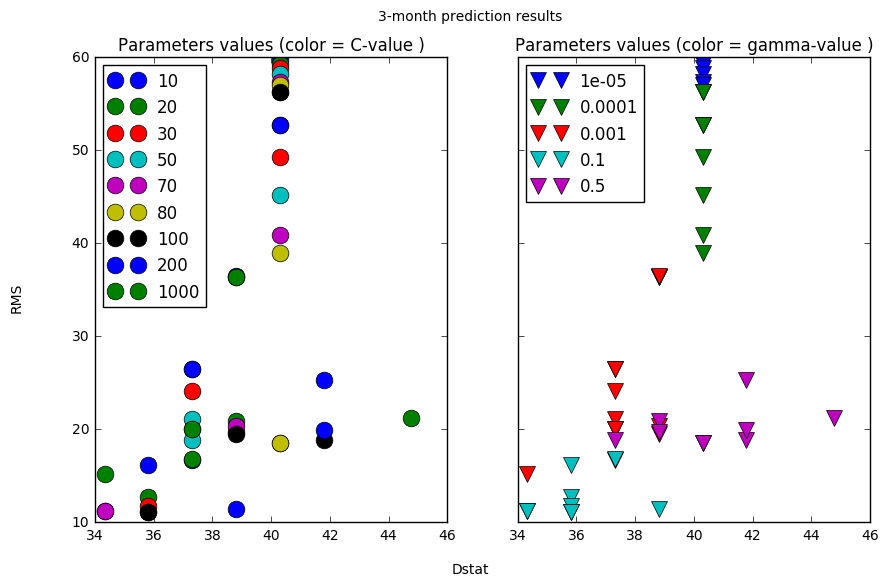


6-month prediction results
      Mean_Dstat  Std_Dstat  Mean_RMSE   Std_RMSE
C                                                
10        48.654   1.332697     37.846  17.541178
20        49.252   3.164304     33.978  18.708207
30        48.954   2.668470     32.036  19.042086
50        49.552   3.234396     29.948  18.695418
70        49.552   2.214412     28.682  18.089478
80        49.254   2.791546     28.288  17.871925
100       48.654   4.299591     27.618  17.289473
200       48.952   4.273695     25.788  14.995582
1000      51.638   3.269904     26.564   7.550836
         Mean_Dstat  Std_Dstat  Mean_RMSE   Std_RMSE
gamma                                               
0.00001   49.250000   0.000000  53.012222   6.803280
0.00010   49.750000   0.750000  39.684444  10.997566
0.00100   49.084444   0.496667  23.151111   5.338744
0.10000   45.772222   3.804000  15.290000   4.236458
0.50000   53.066667   1.844275  19.277778   5.833067


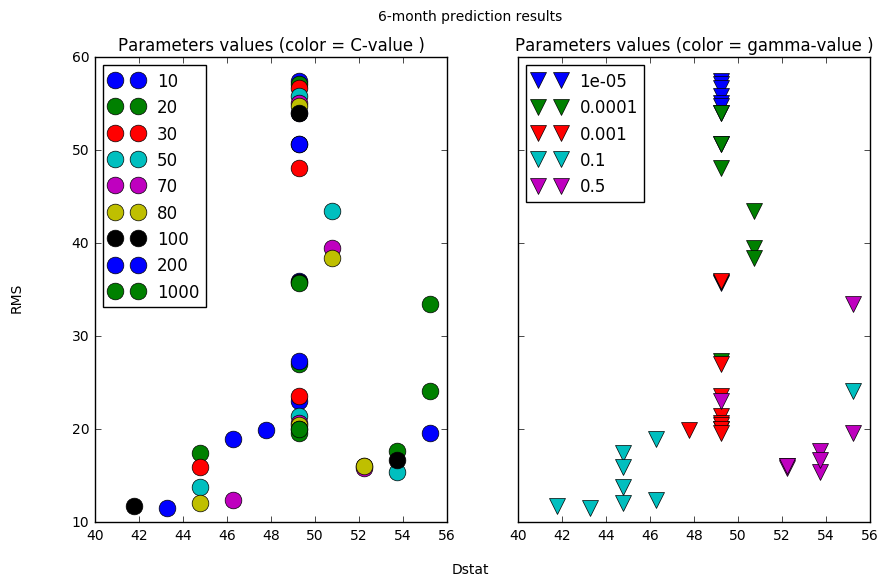

In [103]:
for z in PricePredRange:
    PlotParameterScatter(SVRGridSearchArray, 'C', 'gamma', z)


## Plot best model



### Next month predictor


Testing predicton quality based for 1-month prediction:
For training data RMSE is 5.03 while Direct Accuracy is 52.75:
For testing data RMSE is 7.73 while Direct Accuracy is 59.7:


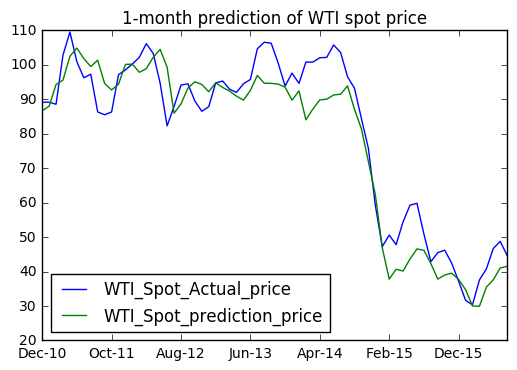

In [18]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(54, input_dim=27, activation='relu'))
model.add(Dense(320))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(X_train.values, y_train, nb_epoch=25, batch_size=2, verbose=0)


PricePredValue = '1'

for x in PricePredValue:
    print "\b"+"\n"+"Testing predicton quality based for {}-month prediction:".format(x)
    y_trainName = 'y_train'+x
    y_testName = 'y_test'+x
    
    model.fit(X_train.values, eval(y_trainName), nb_epoch=100, batch_size=4, verbose=0)
      
    y_predTr = model.predict(X_train.values)
    y_predTr = map (float, y_predTr)
    y_predTr = pd.DataFrame([y_predTr]).T
    y_predTrI = y_predTr.set_index(eval(y_trainName).index)
    print "For training data RMSE is {} while Direct Accuracy is {}:".format(rms(eval(y_trainName), y_predTrI), Dstat(eval(y_trainName), y_predTrI))
    
    y_predTe = model.predict(X_test.values)
    y_predTe = map (float, y_predTe)
    y_predTe = pd.DataFrame([y_predTe]).T
    y_predTeI = y_predTe.set_index(eval(y_testName).index)
    print "For testing data RMSE is {} while Direct Accuracy is {}:".format(rms(eval(y_testName), y_predTeI), Dstat(eval(y_testName), y_predTeI))
    PlotShiftedData(x,eval(y_testName),y_predTe)





### Third month predictor


Testing predicton quality based for 3-month prediction:
For training data RMSE is 8.67 while Direct Accuracy is 53.11:
For testing data RMSE is 11.76 while Direct Accuracy is 44.78:


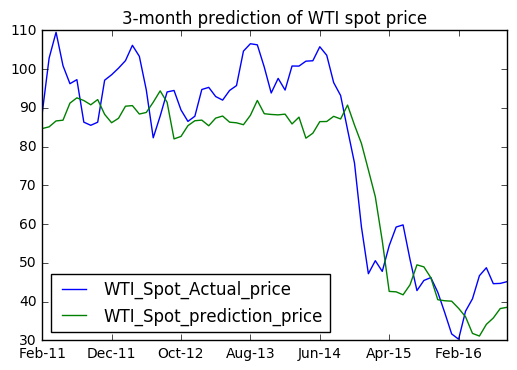

In [54]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(54, input_dim=27, activation='relu'))
model.add(Dense(27))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(X_train.values, y_train, nb_epoch=25, batch_size=2, verbose=0)


PricePredValue = '3'

for x in PricePredValue:
    print "\b"+"\n"+"Testing predicton quality based for {}-month prediction:".format(x)
    y_trainName = 'y_train'+x
    y_testName = 'y_test'+x
    
    model.fit(X_train.values, eval(y_trainName), nb_epoch=100, batch_size=4, verbose=0)
      
    y_predTr = model.predict(X_train.values)
    y_predTr = map (float, y_predTr)
    y_predTr = pd.DataFrame([y_predTr]).T
    y_predTrI = y_predTr.set_index(eval(y_trainName).index)
    print "For training data RMSE is {} while Direct Accuracy is {}:".format(rms(eval(y_trainName), y_predTrI), Dstat(eval(y_trainName), y_predTrI))
    
    y_predTe = model.predict(X_test.values)
    y_predTe = map (float, y_predTe)
    y_predTe = pd.DataFrame([y_predTe]).T
    y_predTeI = y_predTe.set_index(eval(y_testName).index)
    print "For testing data RMSE is {} while Direct Accuracy is {}:".format(rms(eval(y_testName), y_predTeI), Dstat(eval(y_testName), y_predTeI))
    PlotShiftedData(x,eval(y_testName),y_predTe)


### Sixth month predictor


Testing predicton quality based for 6-month prediction:
For training data RMSE is 4.59 while Direct Accuracy is 68.86:
For testing data RMSE is 15.4 while Direct Accuracy is 53.73:


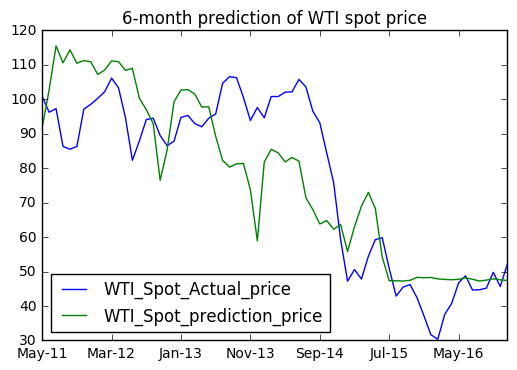

In [19]:
clf = SVR(C=50, gamma =0.5 )

PricePredValue = '6'

for x in PricePredValue:
    y_trainName = 'y_train'+x
    y_testName = 'y_test'+x
      
    clf.fit(X_train, eval(y_trainName))
    
    y_predTr = clf.predict(X_train)
    y_predTr = pd.DataFrame([y_predTr]).T
    y_predTr = y_predTr.set_index(eval(y_trainName).index)
    print "For training data RMSE is {} while Direct Accuracy is {}:".format(rms(eval(y_trainName), y_predTr), Dstat(eval(y_trainName), y_predTr))
    
    y_predTe = clf.predict(X_test)
    y_predTe = pd.DataFrame([y_predTe]).T
    y_predTeI = y_predTe.set_index(eval(y_testName).index)
    print "For testing data RMSE is {} while Direct Accuracy is {}:".format(rms(eval(y_testName), y_predTeI), Dstat(eval(y_testName), y_predTeI))
    PlotShiftedData(x,eval(y_testName),y_predTe)